In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set()
seaborn.set_style('dark')
np.set_printoptions(precision=3)

%matplotlib inline

In [2]:
import sklearn
import sklearn.metrics
import sklearn.grid_search
import sklearn.linear_model
import sklearn.cross_validation
import sklearn.preprocessing
import sklearn.pipeline
import pescador

In [3]:
import glob

In [4]:
def load_file(filename, n_pos=32, n_neg=32):
    
    data = np.load(filename)
    
    d = data['X'].shape[1]
    
    if n_pos is None:
        return data['X'], data['Y']
    
    
    positives = np.flatnonzero(data['Y'])
    negatives = np.flatnonzero(1-data['Y'])
    n_pos = min(n_pos, len(positives))
    n_neg = min(n_neg, len(negatives))
    
    X = np.empty((n_pos + n_neg, d), dtype=np.float32)
    Y = np.zeros((n_pos + n_neg), dtype=np.int32)
    
    if n_pos > 0:
        idx_pos = np.random.choice(positives, size=n_pos, replace=False)
    
        X[:n_pos] = np.take(data['X'], idx_pos, axis=0)
        Y[:n_pos] = 1
    
    if n_neg > 0:
        idx_neg = np.random.choice(negatives, size=n_neg, replace=False)
        X[n_pos:] = np.take(data['X'], idx_neg, axis=0)
    
    return X, Y

In [5]:
def load_batch(files, n_pos=32, n_neg=32):
    
    X = []
    Y = []
    
    for fn in files:
        _x, _y = load_file(fn, n_pos=n_pos, n_neg=n_neg)
        if _x.shape[0] == 0:
            continue
        X.append(_x)
        Y.append(_y)
        
    X = np.concatenate(X, axis=0)
    Y = np.concatenate(Y, axis=0)
    
    return X, Y

In [6]:
files = sorted(glob.glob('../data/labeled_features_local/SALAMI_*_beats.npz'))
#files = sorted(glob.glob('../data/labeled_features_local/Isophonics_*_beats.npz'))

In [7]:
filesplitter = sklearn.cross_validation.ShuffleSplit(len(files), n_iter=1, test_size=0.10, random_state=5)
_files = np.asarray(files)

In [8]:
import sklearn.ensemble

In [15]:
for trainf, testf in filesplitter:
    
    print 'Loading training data...'
    X_train, Y_train = load_batch([_files[_] for _ in trainf],
                                 n_pos=64,
                                 n_neg=128)
    
    _model = sklearn.grid_search.GridSearchCV(sklearn.linear_model.SGDClassifier(loss='log', verbose=1),
                                             {'alpha': np.logspace(-3, 3, num=6, endpoint=False),
                                             'penalty': ['l1', 'l2', 'elasticnet']},
                                             n_jobs=3, verbose=1)
    
    #_model = sklearn.grid_search.GridSearchCV(sklearn.ensemble.RandomForestClassifier(),
    #                                         {'max_depth': np.arange(2, 11)},
    #                                         n_jobs=3, verbose=1)
    
    feature = sklearn.preprocessing.StandardScaler()
    model = sklearn.pipeline.Pipeline([('scaler', feature), ('predictor', _model)])
    
    model.fit(X_train, Y_train)
    
    print 'Loading testing data...'
    X_test, Y_test = load_batch([_files[_] for _ in testf],
                                n_pos=None,
                                n_neg=None)

Loading training data...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=3)]: Done   1 jobs       | elapsed:    3.4s
[Parallel(n_jobs=3)]: Done  50 jobs       | elapsed:   53.0s
[Parallel(n_jobs=3)]: Done  54 out of  54 | elapsed:   57.2s finished


-- Epoch 1
Norm: 0.84, NNZs: 924, Bias: 5.391261, T: 50031, Avg. loss: 0.701671-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 530.37, NNZs: 714, Bias: 415.429404, T: 33354, Avg. loss: 63.364481Norm: 542.85, NNZs: 723, Bias: 442.315999, T: 33353, Avg. loss: 66.142862Norm: 534.95, NNZs: 709, Bias: 416.248419, T: 33355, Avg. loss: 62.347358


Total training time: 0.55 seconds.
Total training time: 0.44 seconds.
Total training time: 0.42 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 517.43, NNZs: 683, Bias: 367.618809, T: 66708, Avg. loss: 50.684128Norm: 528.36, NNZs: 688, Bias: 395.582985, T: 66706, Avg. loss: 53.328181Norm: 521.00, NNZs: 678, Bias: 369.925427, T: 66710, Avg. loss: 50.297497


Total training time: 1.13 seconds.
Total training time: 0.84 seconds.
Total training time: 1.00 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 511.11, NNZs: 662, Bias: 339.616623, T: 100062, Avg. loss: 44.884507Norm: 521.49, NNZs: 667, Bias: 368.073429, T: 100059, Avg. loss: 47.446095Norm: 513.97, NNZs: 

In [16]:
M = model.steps[1][1]

In [17]:
M.best_params_

{'alpha': 0.10000000000000001, 'penalty': 'l2'}

<matplotlib.colorbar.Colorbar instance at 0x7f911c226ea8>

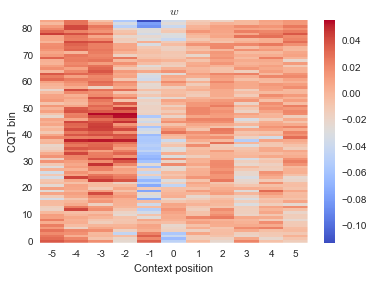

In [18]:
w = model.steps[1][1].best_estimator_.coef_[0]
w = w.reshape((-1, 84))
plt.imshow(w.T, aspect='auto', interpolation='none', cmap='coolwarm', origin='lower')
plt.ylabel('CQT bin')
plt.xlabel('Context position')
plt.title('$w$')
plt.xticks(np.arange(w.shape[0]), np.arange(-(w.shape[0]//2), 1+w.shape[0]//2))
plt.colorbar()

In [19]:
print sklearn.metrics.classification_report(Y_train, model.predict(X_train))

             precision    recall  f1-score   support

          0       0.82      0.14      0.23      7057
          1       0.88      0.99      0.93     42974

avg / total       0.87      0.87      0.83     50031



In [20]:
sklearn.metrics.accuracy_score(Y_train, model.predict(X_train))

0.87391817073414479

In [21]:
Y_pred = [model.predict(xt) for xt in X_test]

In [22]:
Y_pred_proba = np.concatenate([model.predict_proba(xt) for xt in X_test], axis=0)

In [23]:
Y_pred = np.concatenate(Y_pred, axis=0)

In [24]:
print sklearn.metrics.classification_report(Y_test, Y_pred)

             precision    recall  f1-score   support

          0       0.31      0.15      0.20       693
          1       0.99      0.99      0.99     43365

avg / total       0.98      0.98      0.98     44058



In [25]:
sklearn.metrics.accuracy_score(Y_test, Y_pred)

0.98156974896727045

---

In [33]:
import cPickle as pickle

In [49]:
pickle.dump({'model': model, 'dataset': 'salami_beat'},
            open('../data/similarity_model_salami_local_beat.pickle', 'w'))
#pickle.dump({'model': model, 'dataset': 'isophonics_local_beat'},
#            open('../data/similarity_model_isophonics_local_beat.pickle', 'w'))